In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#import dataset
#investigating marital status and overall cognition
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','married_or_livingtogether','abcd_site','site_id_l','race_ethnicity'], index_col=False)


(10843, 5)


In [3]:
#change categorical variable to numerical
data['married_or_livingtogether'].replace(['no','yes'],
                        [0,1], inplace=True)

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected'])
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [8]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
tp = data.married_or_livingtogether.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [9]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
tp_ = shared(tp)

In [10]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from parental marital status 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * tp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 929 seconds.
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'marital status model of overall cognition')

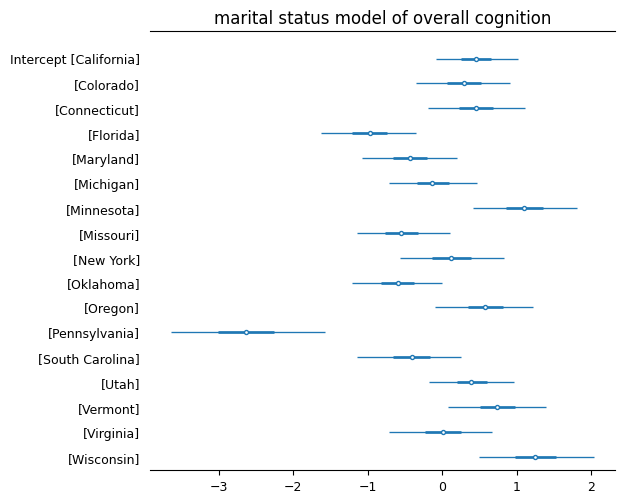

In [11]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("marital status model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_plot_state_intercept_marry_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_25454/4191615672.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'marital status slope effects of overall cognition')

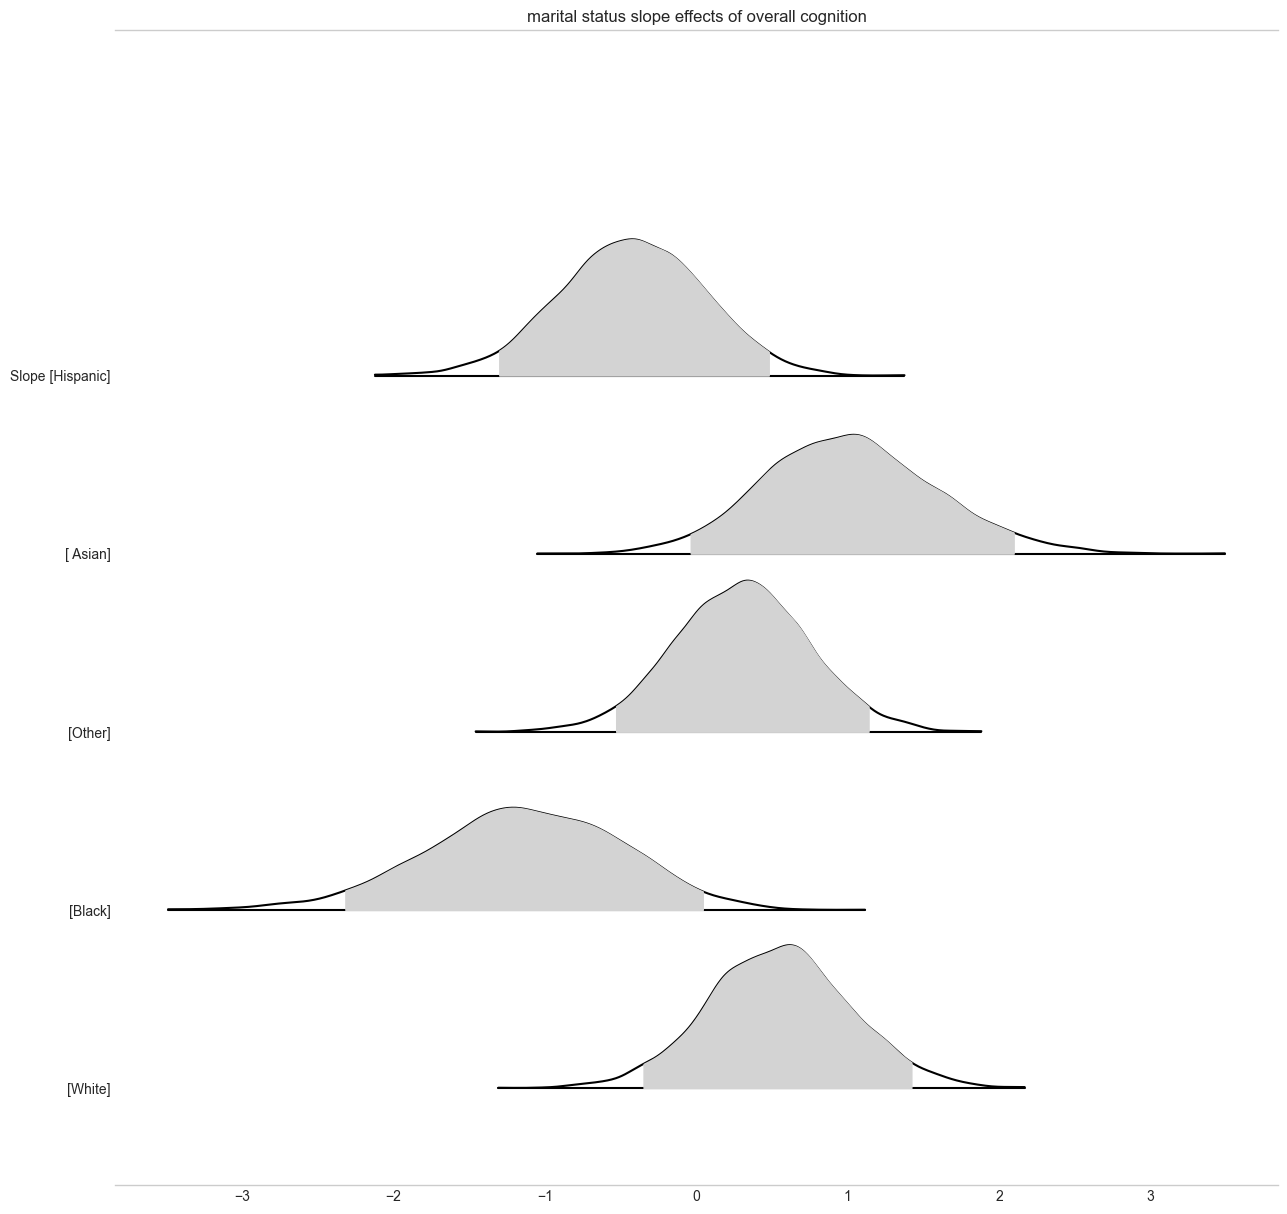

In [12]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("marital status slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
#fig.savefig('forest_ridge_plot_race_slope_marry_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [13]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [14]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.367247
r2_std    0.003522
dtype: float64

In [15]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [16]:
# get race, state and parental marital status columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_tp_df = pd.DataFrame(data['married_or_livingtogether'],columns =['married_or_livingtogether']).reset_index(drop=True)


In [17]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_tp_df,ppc_df,left_index=True, right_index=True)


In [18]:
ppc_tp_race_mean = (ppc_df.groupby(['married_or_livingtogether','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.331899 -0.258908 -0.786963   
                          Black          -0.435841 -0.462401 -0.497162   
                          Hispanic       -0.408333 -0.389958 -0.499320   
                          Other          -0.441846 -0.428545 -0.448519   
                          White          -0.417479 -0.379576 -0.396089   
1                         Asian           0.571090  0.648382  0.495850   
                          Black          -0.525061 -0.597311 -0.615798   
                          Hispanic       -0.185449 -0.182531 -0.195884   
                          Other           0.206473  0.111533  0.147183   
                          White           0.331212  0.311037  0.313549   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.168908 -0.448933 -0.437203   
                          Black          -0.430910 -0.458490 -0.498755   
                          Hispanic       -0.383957 -0.324595 -0.423198   
                          Other          -0.409356 -0.298908 -0.463553   
                          White          -0.408343 -0.334539 -0.320116   
1                         Asian           0.428983  0.514619  0.527169   
                          Black          -0.628338 -0.516813 -0.549542   
                          Hispanic       -0.146903 -0.159611 -0.172277   
                          Other           0.156154  0.178892  0.123448   
                          White           0.340132  0.334538  0.286998   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
married_or_livingtogether race_ethnicity                                 
0                         Asian          -0.111538 -0.247848 -0.732438   
                          Black          -0.517039 -0.485986 -0.454636   
                          Hispanic       -0.336750 -0.403206 -0.355577   
                          Other          -0.441723 -0.492448 -0.461709   
                          White          -0.410428 -0.344043 -0.386974   
1                         Asian           0.463573  0.527856  0.619115   
                          Black          -0.535664 -0.538307 -0.637150   
                          Hispanic       -0.189395 -0.190193 -0.174138   
                          Other           0.174084  0.112654  0.167207   
                          White           0.313867  0.328061  0.328980   

                                          pp_cog_9  ...  pp_cog_7990  \
married_or_livingtogether race_ethnicity            ...                
0                         Asian          -0.045756  ...    -0.470406   
                          Black          -0.451803  ...    -0.500970   
                          Hispanic       -0.458472  ...    -0.383174   
                          Other          -0.458890  ...    -0.460219   
                          White          -0.428151  ...    -0.340884   
1                         Asian           0.567383  ...     0.618193   
                          Black          -0.601142  ...    -0.673032   
                          Hispanic       -0.096968  ...    -0.198253   
                          Other           0.145572  ...     0.202550   
                          White           0.332549  ...     0.301896   

                                          pp_cog_7991  pp_cog_7992  \
married_or_livingtogether race_ethnicity                             
0                         Asian             -0.172966    -0.151417   
                          Black             -0.524680    -0.490273   
                          Hispanic          -0.323481    -0.328972   
                          Other             -0.414281    -0.363686   
                          White             -0.383823    -0.415989   
1                   

In [19]:
ppc_tp_race_mean_summ=ppc_tp_race_mean.mean(axis=1)
ppc_tp_race_mean_summ

married_or_livingtogether  race_ethnicity
0                          Asian            -0.332028
                           Black            -0.470961
                           Hispanic         -0.380543
                           Other            -0.415078
                           White            -0.372556
1                          Asian             0.555064
                           Black            -0.606374
                           Hispanic         -0.174301
                           Other             0.164677
                           White             0.311442
dtype: float64

In [20]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.487268,0.564161,0.376771,0.373482,0.425176,0.437649,0.410187,0.455849,0.493655,0.510467,...,0.517141,0.477289,0.572490,0.436908,0.484599,0.623527,0.607223,0.425826,0.527925,0.341572
Black,-0.470022,-0.514085,-0.542612,-0.506546,-0.480834,-0.518212,-0.524174,-0.506030,-0.524558,-0.509015,...,-0.566888,-0.551784,-0.558267,-0.499011,-0.550886,-0.530963,-0.524072,-0.576232,-0.487403,-0.587774
Hispanic,-0.252835,-0.245244,-0.287624,-0.218573,-0.209492,-0.248139,-0.233946,-0.254595,-0.228994,-0.206264,...,-0.254161,-0.180452,-0.206702,-0.235409,-0.180073,-0.269416,-0.234526,-0.199540,-0.235095,-0.220541
Other,0.025334,-0.039364,-0.019255,-0.001849,0.045395,-0.040560,0.002028,-0.056411,-0.008511,-0.023314,...,0.017374,-0.028535,0.000437,-0.003007,0.019380,-0.057636,0.017033,-0.032980,0.019563,-0.006680
White,0.218356,0.206936,0.206580,0.227309,0.233683,0.195484,0.204689,0.226750,0.221059,0.217883,...,0.205005,0.175862,0.206406,0.215292,0.211541,0.189132,0.179680,0.211891,0.194929,0.211999


In [21]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [22]:
ppc_tp_state_mean = (ppc_df.groupby(['married_or_livingtogether','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_tp_state_mean_summ = ppc_tp_state_mean.mean(axis=1)


In [23]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [24]:
ppc_tp_state_mean_summ_list=ppc_tp_state_mean_summ.to_numpy()
low_tp_state = ppc_tp_state_mean_summ_list[:17]
high_tp_state = ppc_tp_state_mean_summ_list[-17:]

In [25]:
mean_predictions_state = [low_tp_state,high_tp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.296895,-0.321269,-0.295337,-0.538192,-0.446468,-0.396007,-0.187617,-0.467280,-0.352942,-0.474927,-0.275113,-0.820308,-0.442992,-0.304875,-0.248225,-0.371492,-0.161185
1,0.128524,0.217758,0.205241,-0.187897,0.002195,0.130283,0.403046,0.022411,0.176851,0.011380,0.296373,-0.495501,0.052014,0.293242,0.386939,0.117913,0.414224


In [26]:
ppc_tp_race_mean_summ_list=ppc_tp_race_mean_summ.to_numpy()
low_tp_race = ppc_tp_race_mean_summ_list[:5]
high_tp_race = ppc_tp_race_mean_summ_list[-5:]

In [27]:
# initialize list of lists 
mean_predictions_race = [low_tp_race,high_tp_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.332028,-0.470961,-0.380543,-0.415078,-0.372556
1,0.555064,-0.606374,-0.174301,0.164677,0.311442


In [28]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Single_Parent_Fam_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [29]:
val = census_data['Single_Parent_Fam_score'].median()
census_data.loc[census_data['Single_Parent_Fam_score'] < val, 'Single_Parent_Fam_score_bin'] = 0
census_data.loc[census_data['Single_Parent_Fam_score'] >= val, 'Single_Parent_Fam_score_bin'] = 1

In [30]:
census = (census_data.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0.0,768462
1,california,Asian,1.0,1066853
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6091949
...,...,...,...,...
139,wisconsin,Hispanic,1.0,43295
140,wisconsin,Other,0.0,14993
141,wisconsin,Other,1.0,168524
142,wisconsin,White,0.0,2377092


In [31]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,768462,1,0
1,california,Asian,1.0,1066853,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6091949,0,0


In [32]:
#fix theano shared tensor type error
census=census.astype({'Single_Parent_Fam_score_bin':'uint8'})

In [33]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_tp = census.Single_Parent_Fam_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
tp_.set_value(ps_tp)

In [34]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [35]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(144, 8000)

In [36]:
censust=census
censust

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,race_enc,state_enc
0,california,Asian,0,768462,1,0
1,california,Asian,1,1066853,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6091949,0,0
...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,43295,0,16
140,wisconsin,Other,0,14993,2,16
141,wisconsin,Other,1,168524,2,16
142,wisconsin,White,0,2377092,4,16


In [37]:
# get race, state, and parental marital status  columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_tp_df2 = pd.DataFrame(censust['Single_Parent_Fam_score_bin'],columns =['Single_Parent_Fam_score_bin']).reset_index(drop=True)


In [38]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_tp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,768462,-0.009070,-0.121072,0.237938,-0.474685,-0.264531,-2.083159,...,-0.512575,-0.934195,-0.845395,-0.033075,-0.923906,0.672516,0.131542,-0.399394,0.628055,-1.102315
1,california,Asian,1,1066853,1.565600,-1.172521,2.068084,0.954561,-0.923820,1.605236,...,0.601871,1.871753,1.437334,0.891352,1.300604,0.837130,1.521161,1.055466,0.646916,-0.184940
2,california,Black,0,3168044,0.393549,-0.308561,-0.555452,-1.732075,0.824887,1.817171,...,-0.099158,-0.851908,-0.648466,-0.289935,0.303192,-0.588743,0.463747,-0.400677,-0.617506,-0.881499
3,california,Black,1,786431,-1.805926,-2.125906,-2.127865,-0.634493,-0.455408,0.125133,...,0.060208,-1.174092,-0.002760,-1.437203,-1.955641,-0.049337,-0.728949,-2.491358,-0.599824,0.590035
4,california,Hispanic,0,6091949,-1.698250,0.544401,-0.649779,-0.275143,-0.875844,-1.971287,...,0.102774,-1.908615,-0.492435,0.842809,-0.676902,0.369212,-0.328821,-1.130223,0.979504,-0.988533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,43295,-0.646491,0.143318,0.053490,-0.586670,1.031435,0.194872,...,-0.137703,-0.111592,-1.223988,-1.912762,-0.420455,-0.651634,0.257789,-0.635790,0.491517,1.143373
140,wisconsin,Other,0,14993,-0.431302,-0.877353,0.736691,0.107253,-0.009963,0.425579,...,-0.190700,-0.831497,1.714109,-1.243636,0.324347,0.011170,0.989407,0.524075,-1.019099,1.950211
141,wisconsin,Other,1,168524,-0.319745,-0.561307,-0.122072,2.352642,-1.171990,1.119059,...,-0.269434,0.353032,-1.696177,0.138704,0.253614,1.321437,0.991901,0.111388,0.897010,1.303355
142,wisconsin,White,0,2377092,0.291892,0.891219,-1.419648,0.248793,-1.338343,-0.573563,...,-0.079922,0.760480,-0.940182,-0.342815,0.424521,0.246850,-1.238436,1.089401,1.246639,-0.696929


In [39]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Single_Parent_Fam_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -6.969583e+03   
                          1                           1    1.670265e+06   
           Black          0                           2    1.246781e+06   
                          1                           3   -1.420236e+06   
           Hispanic       0                           4   -1.034565e+07   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -2.798981e+04   
           Other          0                           140 -6.466510e+03   
                          1                           141 -5.388466e+04   
           White          0                           142  6.938531e+05   
                          1                           143  3.302237e+05   

                                                               pp_cog_1  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -9.303889e+04   
                          1                           1   -1.250908e+06   
           Black          0                           2   -9.775337e+05   
                          1                           3   -1.671878e+06   
           Hispanic       0                           4    3.316461e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139  6.204940e+03   
           Other          0                           140 -1.315416e+04   
                          1                           141 -9.459368e+04   
           White          0                           142  2.118510e+06   
                          1                           143  2.108948e+06   

                                                               pp_cog_2  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0    1.828460e+05   
                          1                           1    2.206342e+06   
           Black          0                           2   -1.759696e+06   
                          1                           3   -1.673419e+06   
           Hispanic       0                           4   -3.958423e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139  2.315830e+03   
           Other          0                           140  1.104521e+04   
                          1                           141 -2.057213e+04   
           White          0                           142 -3.374634e+06   
                          1                           143  2.283057e+06   

                                                               pp_cog_3  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
california Asian          0                           0   -3.647774e+05   
                          1                           1    1.018376e+06   
           Black          0                           2   -5.487290e+06   
                          1                           3   -4.989847e+05   
           Hispanic       0                           4   -1.676156e+06   
...                                                                 ...   
wisconsin  Hispanic       1                           139 -2.539987e+04   
           Other          0                           140  1.608038e+03   
                          1                           141  3.964766e+05   
           White          0                           142  5.914044e+05   
                          1                           143  2.551891e+05   

                                                               pp_cog_4  \
state      race_ethnicity Single_Parent_Fam_score_bin                     
californi

In [40]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-6.969583e+03,-9.303889e+04,1.828460e+05,-3.647774e+05,-2.032824e+05,-1.600829e+06,-5.587377e+05,2.335423e+05,6.842148e+05,1.536570e+06,...,-3.938944e+05,-7.178937e+05,-6.496536e+05,-2.541660e+04,-7.099867e+05,5.168027e+05,1.010850e+05,-3.069192e+05,4.826361e+05,-8.470874e+05
1,1.670265e+06,-1.250908e+06,2.206342e+06,1.018376e+06,-9.855803e+05,1.712551e+06,1.758908e+06,-6.172569e+04,1.175368e+06,2.424226e+06,...,6.421080e+05,1.996886e+06,1.533424e+06,9.509417e+05,1.387553e+06,8.930946e+05,1.622856e+06,1.126027e+06,6.901644e+05,-1.973033e+05
2,1.246781e+06,-9.775337e+05,-1.759696e+06,-5.487290e+06,2.613277e+06,5.756877e+06,-4.742649e+06,-2.109562e+06,-4.254127e+06,-2.095209e+06,...,-3.141379e+05,-2.698883e+06,-2.054369e+06,-9.185254e+05,9.605244e+05,-1.865165e+06,1.469172e+06,-1.269361e+06,-1.956288e+06,-2.792628e+06
3,-1.420236e+06,-1.671878e+06,-1.673419e+06,-4.989847e+05,-3.581471e+05,9.840830e+04,-1.861768e+05,1.142677e+06,3.024501e+05,1.211036e+06,...,4.734950e+04,-9.233420e+05,-2.170937e+03,-1.130261e+06,-1.537977e+06,-3.879992e+04,-5.732681e+05,-1.959281e+06,-4.717198e+05,4.640220e+05
4,-1.034565e+07,3.316461e+06,-3.958423e+06,-1.676156e+06,-5.335598e+06,-1.200898e+07,4.258888e+06,-8.087431e+05,3.402444e+06,-8.823296e+06,...,6.260932e+05,-1.162718e+07,-2.999886e+06,5.134350e+06,-4.123653e+06,2.249218e+06,-2.003160e+06,-6.885264e+06,5.967090e+06,-6.022092e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-2.798981e+04,6.204940e+03,2.315830e+03,-2.539987e+04,4.465599e+04,8.436991e+03,5.200409e+04,1.596883e+04,1.875290e+04,1.863059e+04,...,-5.961851e+03,-4.831382e+03,-5.299255e+04,-8.281304e+04,-1.820361e+04,-2.821249e+04,1.116097e+04,-2.752653e+04,2.128023e+04,4.950233e+04
140,-6.466510e+03,-1.315416e+04,1.104521e+04,1.608038e+03,-1.493717e+02,6.380708e+03,-1.234995e+04,-2.094302e+04,-2.695177e+04,-4.129823e+04,...,-2.859163e+03,-1.246663e+04,2.569964e+04,-1.864584e+04,4.862930e+03,1.674722e+02,1.483417e+04,7.857457e+03,-1.527935e+04,2.923952e+04
141,-5.388466e+04,-9.459368e+04,-2.057213e+04,3.964766e+05,-1.975084e+05,1.885883e+05,1.807934e+05,1.373786e+05,1.300055e+05,1.424105e+05,...,-4.540607e+04,5.949435e+04,-2.858465e+05,2.337498e+04,4.274002e+04,2.226939e+05,1.671591e+05,1.877153e+04,1.511678e+05,2.196466e+05
142,6.938531e+05,2.118510e+06,-3.374634e+06,5.914044e+05,-3.181365e+06,-1.363412e+06,-7.166625e+06,-6.643431e+05,-1.006346e+05,-3.385940e+05,...,-1.899816e+05,1.807730e+06,-2.234899e+06,-8.149020e+05,1.009126e+06,5.867841e+05,-2.943876e+06,2.589607e+06,2.963375e+06,-1.656665e+06


In [41]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq
0,california,Asian,0,768462
1,california,Asian,1,1066853
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6091949
...,...,...,...,...
139,wisconsin,Hispanic,1,43295
140,wisconsin,Other,0,14993
141,wisconsin,Other,1,168524
142,wisconsin,White,0,2377092


In [42]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Single_Parent_Fam_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,768462,-6.969583e+03,-9.303889e+04,1.828460e+05,-3.647774e+05,-2.032824e+05,-1.600829e+06,...,-3.938944e+05,-7.178937e+05,-6.496536e+05,-2.541660e+04,-7.099867e+05,5.168027e+05,1.010850e+05,-3.069192e+05,4.826361e+05,-8.470874e+05
1,california,Asian,1,1066853,1.670265e+06,-1.250908e+06,2.206342e+06,1.018376e+06,-9.855803e+05,1.712551e+06,...,6.421080e+05,1.996886e+06,1.533424e+06,9.509417e+05,1.387553e+06,8.930946e+05,1.622856e+06,1.126027e+06,6.901644e+05,-1.973033e+05
2,california,Black,0,3168044,1.246781e+06,-9.775337e+05,-1.759696e+06,-5.487290e+06,2.613277e+06,5.756877e+06,...,-3.141379e+05,-2.698883e+06,-2.054369e+06,-9.185254e+05,9.605244e+05,-1.865165e+06,1.469172e+06,-1.269361e+06,-1.956288e+06,-2.792628e+06
3,california,Black,1,786431,-1.420236e+06,-1.671878e+06,-1.673419e+06,-4.989847e+05,-3.581471e+05,9.840830e+04,...,4.734950e+04,-9.233420e+05,-2.170937e+03,-1.130261e+06,-1.537977e+06,-3.879992e+04,-5.732681e+05,-1.959281e+06,-4.717198e+05,4.640220e+05
4,california,Hispanic,0,6091949,-1.034565e+07,3.316461e+06,-3.958423e+06,-1.676156e+06,-5.335598e+06,-1.200898e+07,...,6.260932e+05,-1.162718e+07,-2.999886e+06,5.134350e+06,-4.123653e+06,2.249218e+06,-2.003160e+06,-6.885264e+06,5.967090e+06,-6.022092e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,wisconsin,Hispanic,1,43295,-2.798981e+04,6.204940e+03,2.315830e+03,-2.539987e+04,4.465599e+04,8.436991e+03,...,-5.961851e+03,-4.831382e+03,-5.299255e+04,-8.281304e+04,-1.820361e+04,-2.821249e+04,1.116097e+04,-2.752653e+04,2.128023e+04,4.950233e+04
140,wisconsin,Other,0,14993,-6.466510e+03,-1.315416e+04,1.104521e+04,1.608038e+03,-1.493717e+02,6.380708e+03,...,-2.859163e+03,-1.246663e+04,2.569964e+04,-1.864584e+04,4.862930e+03,1.674722e+02,1.483417e+04,7.857457e+03,-1.527935e+04,2.923952e+04
141,wisconsin,Other,1,168524,-5.388466e+04,-9.459368e+04,-2.057213e+04,3.964766e+05,-1.975084e+05,1.885883e+05,...,-4.540607e+04,5.949435e+04,-2.858465e+05,2.337498e+04,4.274002e+04,2.226939e+05,1.671591e+05,1.877153e+04,1.511678e+05,2.196466e+05
142,wisconsin,White,0,2377092,6.938531e+05,2.118510e+06,-3.374634e+06,5.914044e+05,-3.181365e+06,-1.363412e+06,...,-1.899816e+05,1.807730e+06,-2.234899e+06,-8.149020e+05,1.009126e+06,5.867841e+05,-2.943876e+06,2.589607e+06,2.963375e+06,-1.656665e+06


In [43]:
#final step of poststratification - by race & marital status 
#data-weighted average
ppc_tp_race_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.138388 -0.358300 -0.815231   
                            Black          -0.548211 -0.323716 -1.112597   
                            Hispanic       -0.890422  0.258329 -0.399476   
                            Other          -0.843949 -0.864067 -0.268132   
                            White          -0.712094 -0.463788 -0.737237   
1                           Asian          -0.014537  1.010694  0.212143   
                            Black          -0.907744 -0.171843 -0.781261   
                            Hispanic       -1.253409  0.800406 -0.224249   
                            Other           1.186349  0.485312  0.105861   
                            White           0.371320  0.198972 -0.189711   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian           0.546489 -0.594063  0.158894   
                            Black          -0.813520 -0.341137  0.041329   
                            Hispanic       -0.283635 -1.064146 -1.490733   
                            Other          -0.510392  0.103875 -1.430858   
                            White          -0.398358 -0.647186 -0.657221   
1                           Asian           0.739893  0.430552  0.880993   
                            Black          -0.955030 -0.366719 -0.681437   
                            Hispanic       -0.395263  0.407309 -0.333921   
                            Other          -0.651691  0.908842 -0.077874   
                            White           0.173505 -0.156812  0.687630   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
Single_Parent_Fam_score_bin race_ethnicity                                 
0                           Asian          -0.660010 -0.556595 -0.272614   
                            Black          -1.257347 -0.834183 -0.771380   
                            Hispanic        0.263602 -0.027731  0.107593   
                            Other          -0.178576 -1.354646 -1.170034   
                            White          -0.597592 -0.187655 -0.488005   
1                           Asian           0.416859  0.835607  0.487804   
                            Black          -0.639029 -0.291021 -0.175588   
                            Hispanic       -1.115973 -0.454940 -0.007446   
                            Other          -0.466892 -0.627624  0.103033   
                            White          -0.063585  0.081026  0.445877   

                                            pp_cog_9  ...  pp_cog_7990  \
Single_Parent_Fam_score_bin race_ethnicity            ...                
0                           Asian          -0.924269  ...    -0.175259   
                            Black          -0.487948  ...    -0.474533   
                            Hispanic       -0.941935  ...    -0.419941   
                            Other          -0.213743  ...    -0.815022   
                            White          -0.523235  ...     0.273369   
1                           Asian           0.672291  ...     0.576104   
                            Black          -0.464481  ...     0.045122   
                            Hispanic       -0.729264  ...    -0.604272   
                            Other          -0.692261  ...    -0.059107   
                            White           0.257398  ...     0.061381   

                                            pp_cog_7991  pp_cog_7992  \
Single_Parent_Fam_score_bin race_ethnicity                             
0                           Asian             -0.617752    -0.820002   
                            Black             -0.342832    -0.305474   
                            Hispanic          -1.056595    -0.464835   
                            Other             -1.037531 

In [44]:
#summarize race & marital status poststrat results
ppc_tp_race_poststrat_summ = ppc_tp_race_poststrat.mean(axis=1)
ppc_tp_race_poststrat_summ

Single_Parent_Fam_score_bin  race_ethnicity
0                            Asian            -0.441055
                             Black            -0.403613
                             Hispanic         -0.330943
                             Other            -0.464601
                             White            -0.395163
1                            Asian             0.506191
                             Black            -0.568755
                             Hispanic         -0.235542
                             Other             0.161859
                             White             0.254523
dtype: float64

In [45]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.128445
Black      -0.484589
Hispanic   -0.272443
Other      -0.081415
White       0.008336
dtype: float64

In [46]:
#for the lollipops
#final step poststrat - by state & marital status
ppc_tp_state_poststrat = ppc_poststrat_df.groupby(['Single_Parent_Fam_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_tp_state_poststrat_summ = ppc_tp_state_poststrat.mean(axis=1)
ppc_tp_state_poststrat_summ

Single_Parent_Fam_score_bin  state        
0                            california      -0.298839
                             colorado        -0.314133
                             connecticut     -0.297936
                             florida         -0.534568
                             maryland        -0.442144
                             michigan        -0.403096
                             minnesota       -0.189371
                             missouri        -0.464477
                             newyork         -0.342872
                             oklahoma        -0.481657
                             oregon          -0.270968
                             pennsylvania    -0.825563
                             southcarolina   -0.442079
                             utah            -0.306385
                             vermont         -0.251704
                             virginia        -0.378674
                             wisconsin       -0.160365
1                     

In [47]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.029965
colorado        -0.054917
connecticut      0.080271
florida         -0.324957
maryland        -0.461646
michigan        -0.071368
minnesota        0.342281
missouri        -0.168729
newyork         -0.117458
oklahoma         0.003746
oregon           0.052567
pennsylvania    -0.445938
southcarolina   -0.198438
utah            -0.243128
vermont         -0.046561
virginia        -0.205787
wisconsin        0.243952
dtype: float64

In [48]:
ppc_tp_state_poststrat_summ_list=ppc_tp_state_poststrat_summ.tolist()

In [49]:
#fill in missing value for connecticut
ppc_tp_state_poststrat_summ_list.insert(19,ppc_tp_state_mean_summ.iloc[19])

In [50]:
low_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[:17]
high_tp_state_poststrat = ppc_tp_state_poststrat_summ_list[-17:]

In [51]:
ppc_tp_race_poststrat_summ_list=ppc_tp_race_poststrat_summ.tolist()

In [52]:
low_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[:5]
high_tp_race_poststrat = ppc_tp_race_poststrat_summ_list[-5:]

In [53]:
mean_predictions_state_ps = [low_tp_state_poststrat,high_tp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.298839,-0.314133,-0.297936,-0.534568,-0.442144,-0.403096,-0.189371,-0.464477,-0.342872,-0.481657,-0.270968,-0.825563,-0.442079,-0.306385,-0.251704,-0.378674,-0.160365
1,0.158588,0.205241,0.335366,-0.203427,-0.479586,0.105297,0.520935,-0.078759,0.047226,0.107625,0.312401,-0.171848,-0.143717,0.329544,0.225312,0.024594,0.555752


In [54]:
# initialize list of lists 
mean_predictions_race_ps = [low_tp_race_poststrat,high_tp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.441055,-0.403613,-0.330943,-0.464601,-0.395163
1,0.506191,-0.568755,-0.235542,0.161859,0.254523


In [55]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

#quantiles_state,quantiles_state_ps

In [56]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

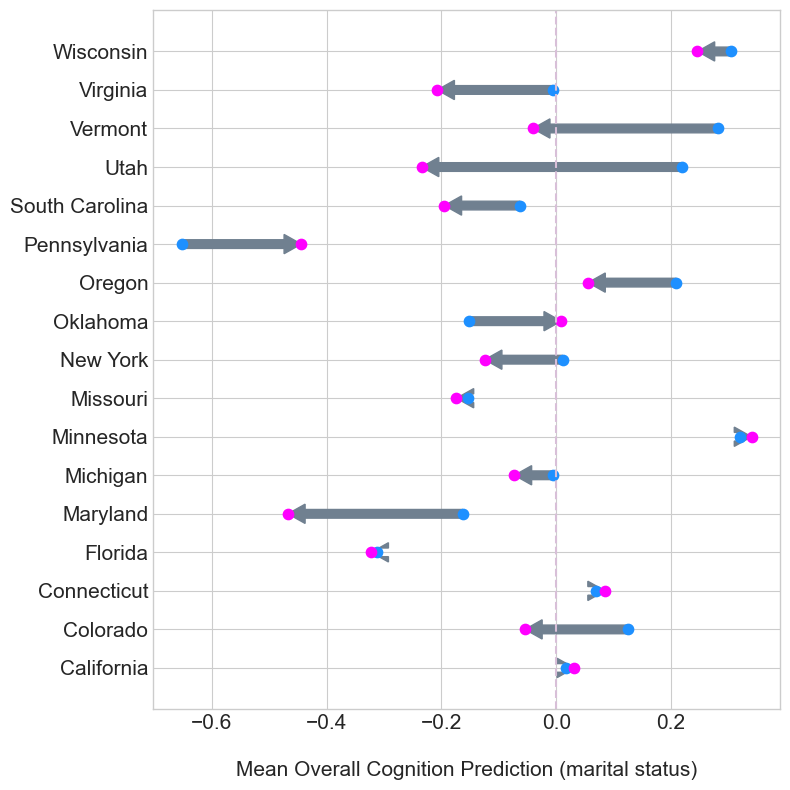

In [57]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (marital status)',size=15,labelpad=20)
#plt.title('Mean Predictions of overall Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_overall_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [58]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

#quantiles_race,quantiles_race_ps

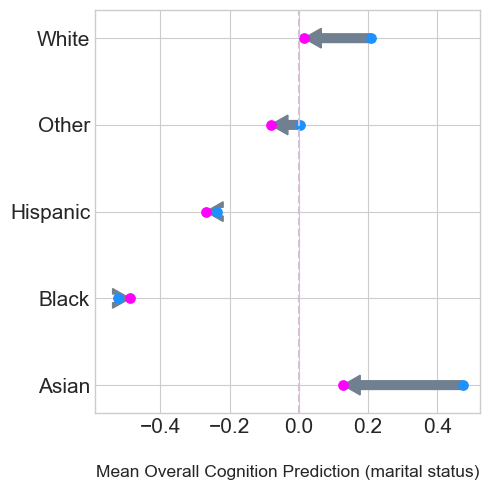

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (marital status)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of overall Cognition based on Marital Status Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
#plt.savefig('arrow_plot_marry_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_25454/1226274042.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_25454/1226274042.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


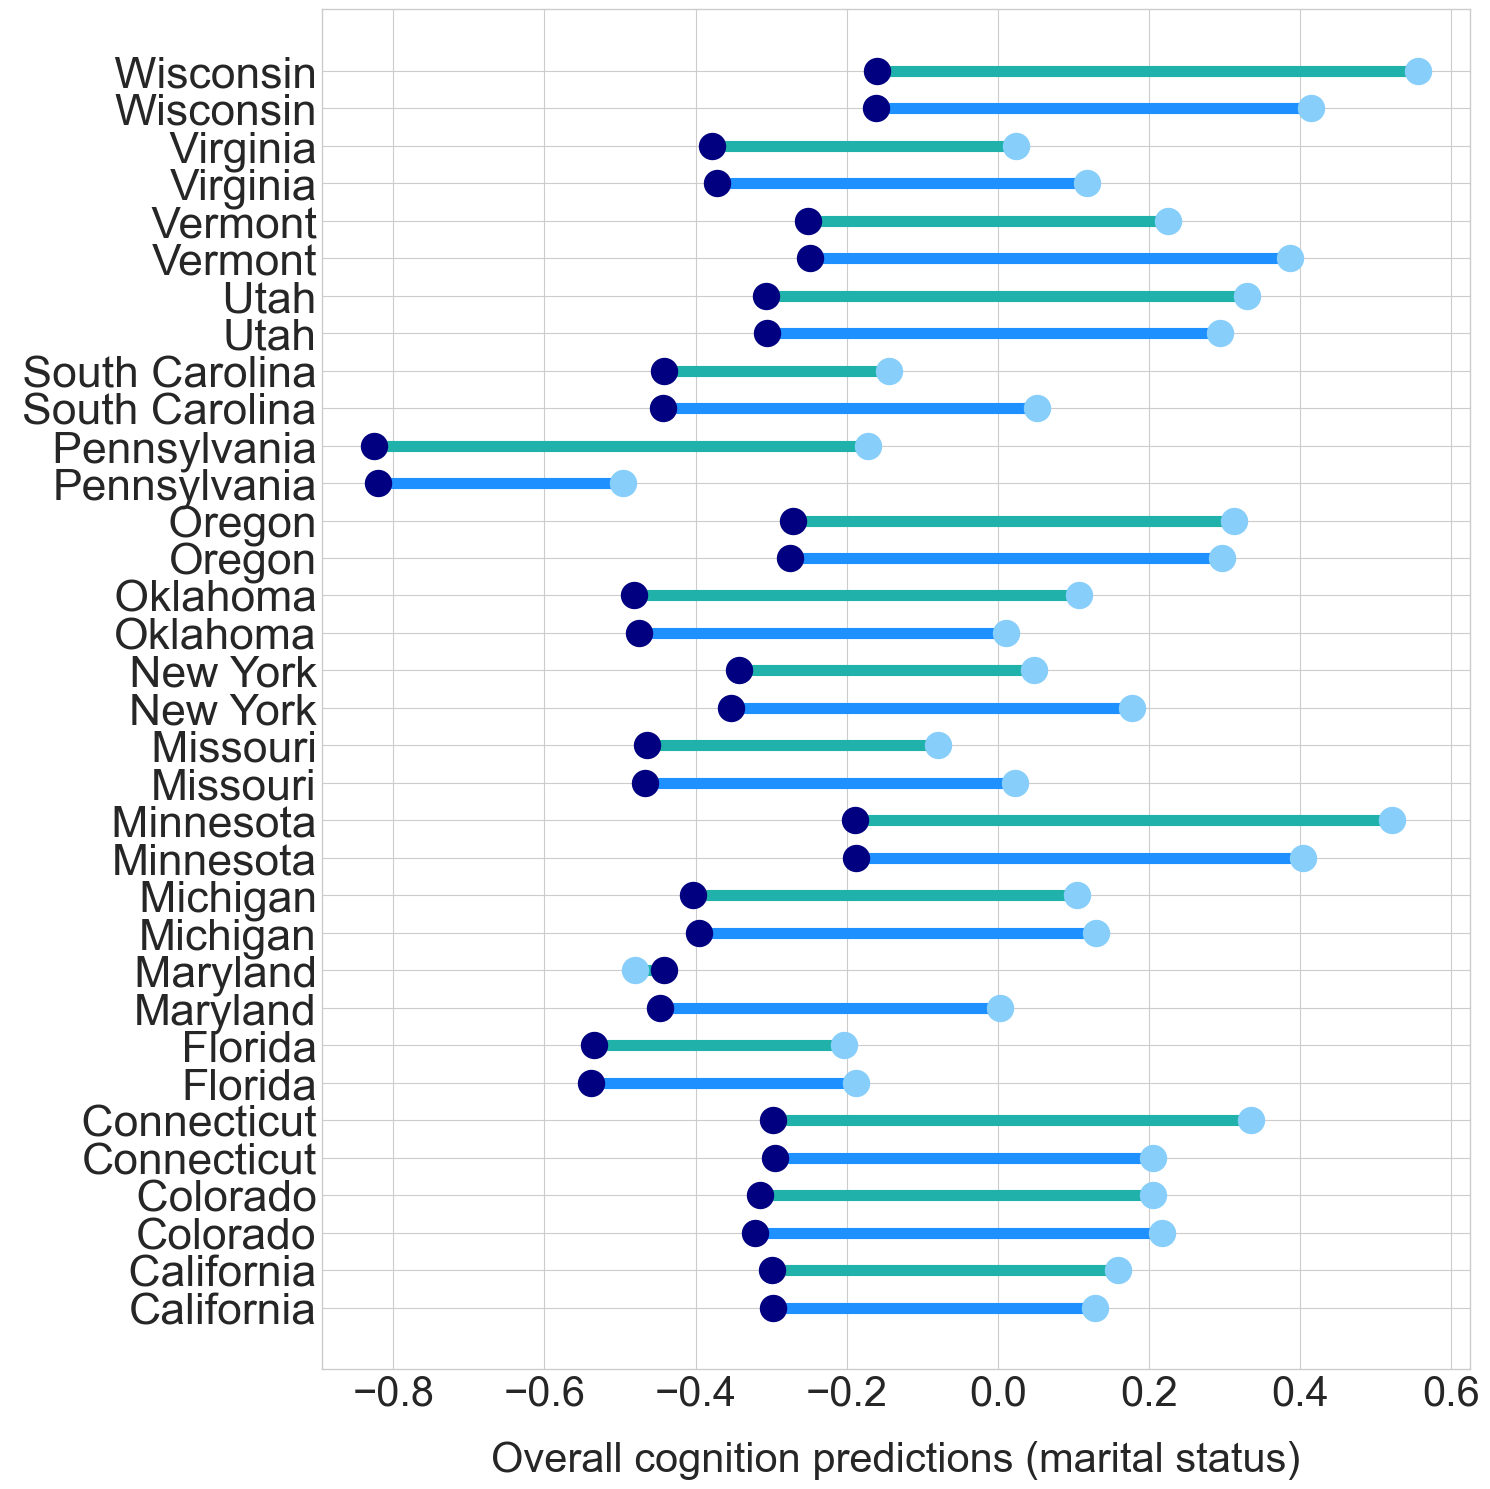

In [60]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','tp HH', 'sp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_overall_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_25454/984831505.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_25454/984831505.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


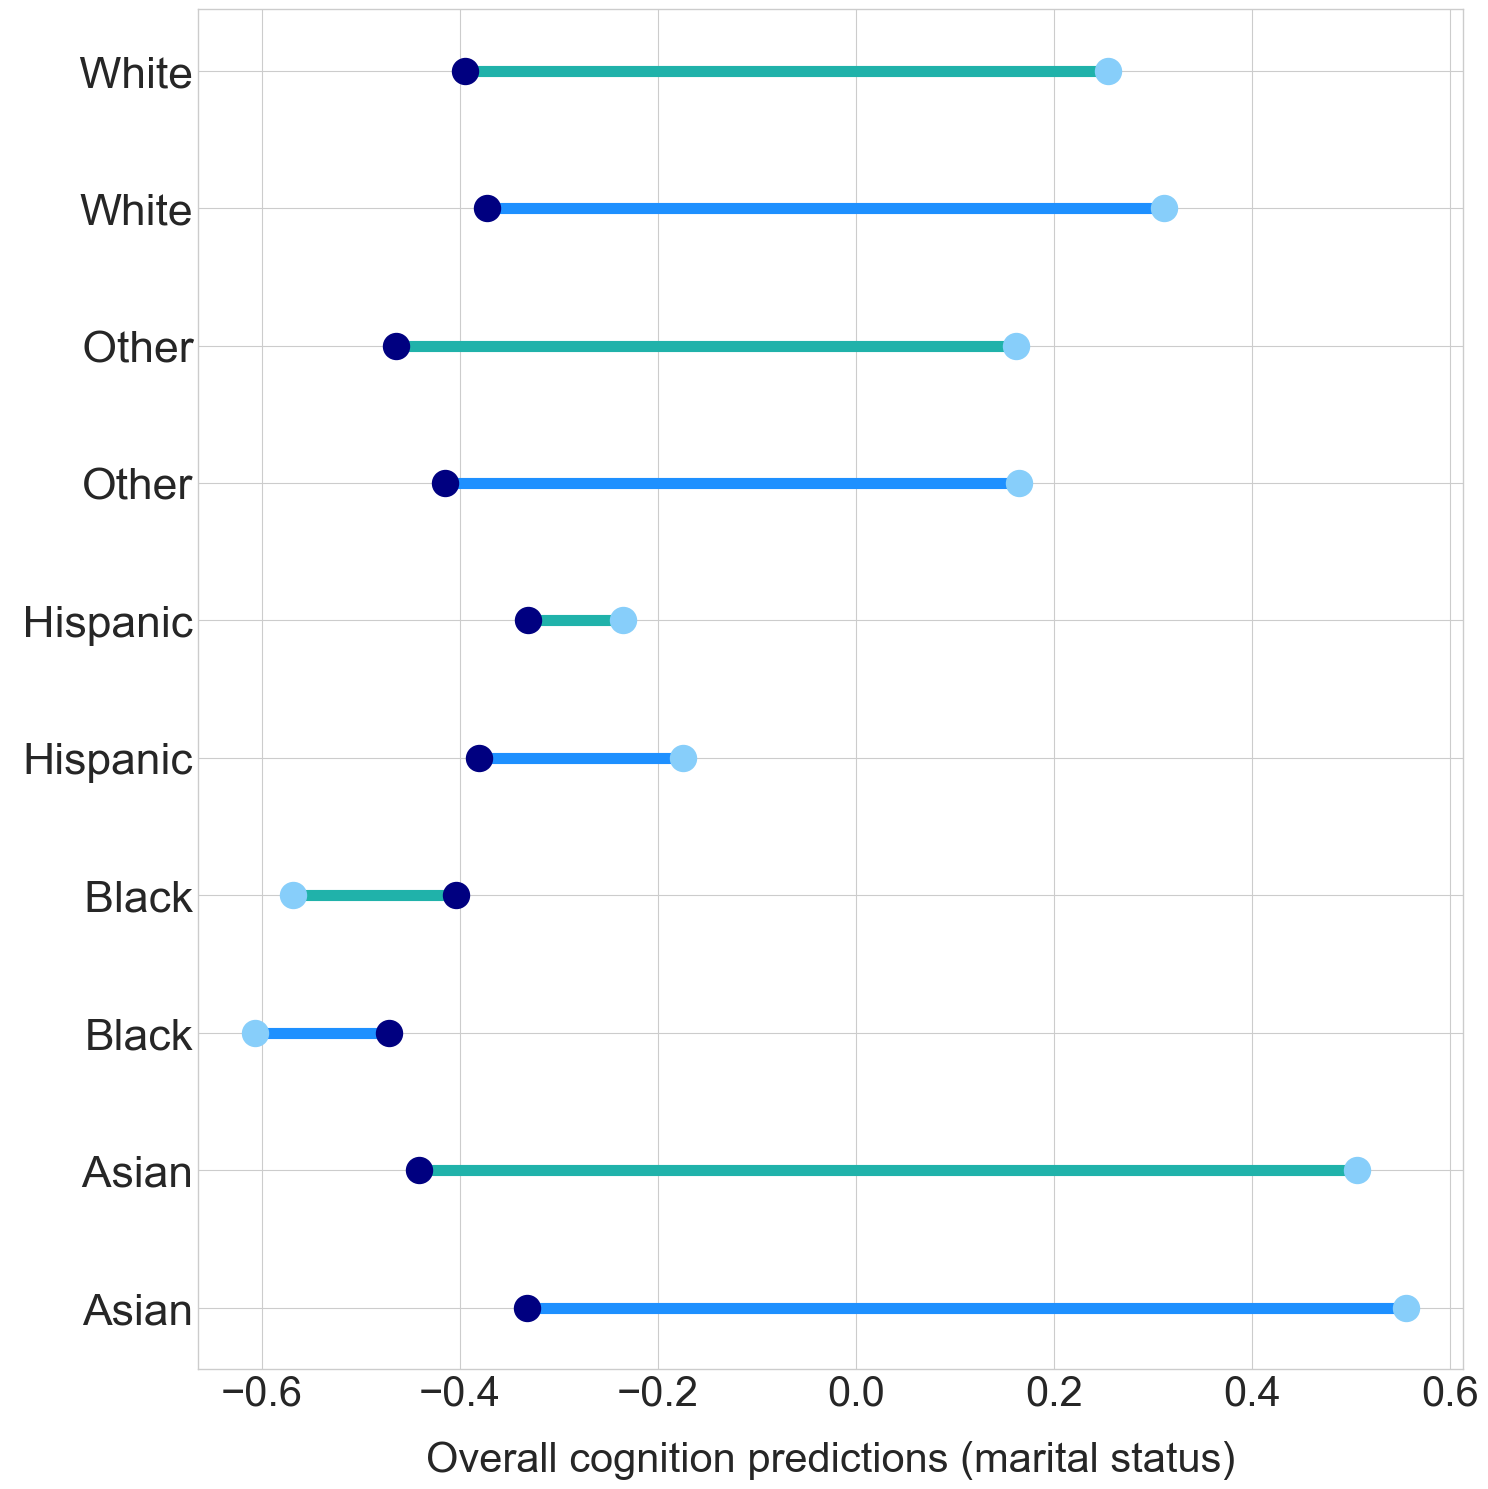

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='dodgerblue', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='lightseagreen', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='navy', label='sp HH', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='lightskyblue', label='tp HH', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='navy', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='lightskyblue', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (marital status)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','sp HH', 'tp HH'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
#plt.savefig('lolli_plot_marry_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()